In [124]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [125]:
class IdealGas():
    """
    Base class for defining an ideal gas and computing its pressure-volume work
    """
    def __init__(self, n, temp_i, vol_i):
        """
        IdealGas(n, temp_i, vol_i)
        
        Parameters:
        ----------------------------
        n (mol): number of moles of ideal gas
        temp_i (K): initial temperature
        vol_i (m^3): initial volume
        """
        self.n = n
        self.temp_i = temp_i
        self.vol_i = vol_i
        self.R = 8.314 # J/mol-K
    
    def pressure_at(self, **kwargs):
        """
        Calculates the pressure with the given conditions
        
        Parameters:
        -----------------------------
        **kwargs: default calculation assumes an isotherm and needs argument `vol`. Default value is 1 m^3.
        
        Returns:
        Pressure (Pa) at the given condition
        """
        return self.n*self.R*self.temp_i/kwargs.get('vol', 1)
        
    def work(self, vol_i, vol_f):
        """
        Computes the work done from vol_i to vol_f
        
        Parameters:
        -----------------------------
        vol_i (m^3): initial volume
        vol_f (m^3): final volume
        
        Returns:
        Work done from vol_i to vol_f (J)
        """
        from scipy.integrate import trapezoid
        import numpy as np
        x = np.linspace(vol_i, vol_f, 1000)
        y = np.array([self.pressure_at(vol) for vol in x])
        work = -trapezoid(y, x)
        return work

In [126]:
class IsothermalIdealGas(IdealGas):
	"""
	Defines an ideal gas under isothermal conditions
	"""
	def pressure_at(self, vol): # override
		"""
		Calculates the pressure at the given volume.

		Parameters:
		-----------------------------
		vol (m^3): current volume.

		Returns:
		Pressure (Pa) at the current volume
		"""
		return self.n*self.R*self.temp_i/vol

In [127]:
def compute_work_isothermal(vol_i, vol_f, n=1, temp=298):
    """
	Computes the work done on an ideal gas undergoing isothermal expansion

	Parameters:
	-----------------------------
	vol_i (m^3): initial volume
	vol_f (m^3): final volume
	n (mol): number of moles
	temp (K): temperature

	Returns:
	Work done from vol_i to vol_f (J)
	"""
    isotherm = IsothermalIdealGas(n, temp, vol_i)
    return isotherm.work(vol_i, vol_f)

In [128]:
compute_work_isothermal(1, 2, temp=100)

np.float64(-576.2826179841131)

In [129]:
class AdiabaticIdealGas(IdealGas):
    """ 
    Defines an ideal gas under adiabatic conditions 
    """
    def __init__(self, n, temp_i, vol_i, gamma): # override 
        """ 
        AdiabaticIdealGas(n, temp_i, vol_i, gamma) 
        Parameters:
        ---------------------------- 
        n (mol): number of moles of ideal gas
        temp_i (K): initial temperature 
        vol_i (m^3): initial volume 
        gamma: adiabatic index of the ideal gas 
        """ 
        super().__init__(n, temp_i, vol_i) 
        self.gamma = gamma 
        p_i = n*self.R*temp_i/vol_i # compute initial pressure 
        self.constant = p_i * vol_i**gamma 
    
    def pressure_at(self, vol): # override 
        """ 
        Calculates the pressure at the given volume. 
        
        Parameters: 
        ----------------------------- 
        vol (m^3): current volume. 
        
        Returns: 
        Pressure (Pa) at the current volume 
        """ 
        return self.constant / (vol**self.gamma)

In [130]:
def compute_work_adiabatic(vol_i, vol_f, gamma, n=1, temp_i=298):
    """
	Computes the work done on an ideal gas undergoing adiabatic expansion

	Parameters:
	-----------------------------
	vol_i (m^3): initial volume
	vol_f (m^3): final volume
    gamma: the adiabatic index of the ideal gas
	n (mol): number of moles
	temp_i (K): initial temperature

	Returns:
	Work done from vol_i to vol_f (J)
	"""
    adiabat = AdiabaticIdealGas(n, temp_i, vol_i, gamma)
    return adiabat.work(vol_i, vol_f)

In [131]:
compute_work_adiabatic(1, 2, 1.4, temp_i=100)

np.float64(-503.2916370307656)

In [132]:
n = 1 # mol
temp_i = 300 # K
v_i = 0.1 # m^3
gamma = 1.4

In [136]:
vols = np.linspace(v_i, 3*v_i, 100)
works = pd.DataFrame({'final_volume': vols})
works['isothermal'] = works['final_volume'].apply(lambda v_f: compute_work_isothermal(v_i, v_f, n, temp_i))
works['adiabatic'] = works['final_volume'].apply(lambda v_f: compute_work_adiabatic(v_i, v_f, gamma, n, temp_i))
works.to_csv('work.csv')

In [134]:
plt_works = works.melt(
    id_vars='final_volume',
    value_vars=['isothermal', 'adiabatic'],
    var_name='condition',
    value_name='work'
)

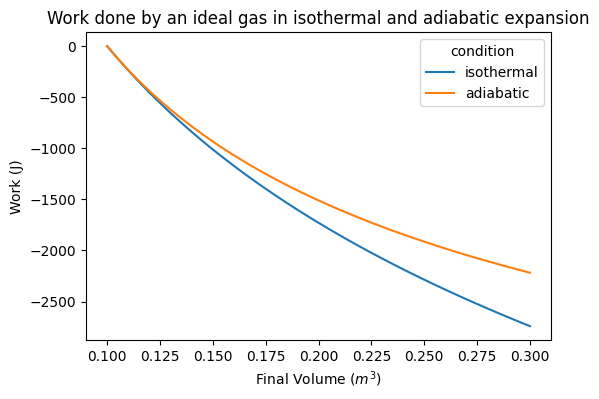

In [141]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(plt_works, x='final_volume', y='work', hue='condition')
ax.set_ylabel('Work (J)')
ax.set_xlabel('Final Volume ($m^3$)')
ax.set_title('Work done by an ideal gas in isothermal and adiabatic expansion')
fig.savefig('work.png', dpi=210)

The work done by an ideal gas on the surroundings in an isothermal expansion is always greater than the work done in an adiabatic process for the same volume change. This makes chemical sense. $\Delta U = w + q$, in the adiabatic process, $q=0$, $w<0$, so $\Delta U<0$. Since $\Delta U = n C_v \Delta T$ for ideal gas, $\Delta T<0$. The ideal gas law states that $PV=nRT$, so if $T$ decreases, $P$ must also decrease. Therefore for the adiabatic process, the pressure integrand is also less than that in the isothermal process.